Loading Data...
Setting up Preprocessing...
Starting Grid Search...
[1/48] depth=None, leaf=1, max_feat=sqrt | OOF_F1=0.6890 thr=0.708 | TEST_F1=0.6667 | TEST_F2=0.6917
[2/48] depth=None, leaf=1, max_feat=0.5 | OOF_F1=0.6898 thr=0.738 | TEST_F1=0.6650 | TEST_F2=0.6880
[3/48] depth=None, leaf=1, max_feat=0.8 | OOF_F1=0.6870 thr=0.733 | TEST_F1=0.6675 | TEST_F2=0.6950
[4/48] depth=None, leaf=2, max_feat=sqrt | OOF_F1=0.6883 thr=0.729 | TEST_F1=0.6641 | TEST_F2=0.6785
[5/48] depth=None, leaf=2, max_feat=0.5 | OOF_F1=0.6950 thr=0.740 | TEST_F1=0.6716 | TEST_F2=0.6968
[6/48] depth=None, leaf=2, max_feat=0.8 | OOF_F1=0.6924 thr=0.734 | TEST_F1=0.6667 | TEST_F2=0.6932
[7/48] depth=None, leaf=4, max_feat=sqrt | OOF_F1=0.6889 thr=0.731 | TEST_F1=0.6607 | TEST_F2=0.6710
[8/48] depth=None, leaf=4, max_feat=0.5 | OOF_F1=0.6972 thr=0.740 | TEST_F1=0.6708 | TEST_F2=0.6964
[9/48] depth=None, leaf=4, max_feat=0.8 | OOF_F1=0.6935 thr=0.755 | TEST_F1=0.6642 | TEST_F2=0.6861
[10/48] depth=None, leaf=8, m

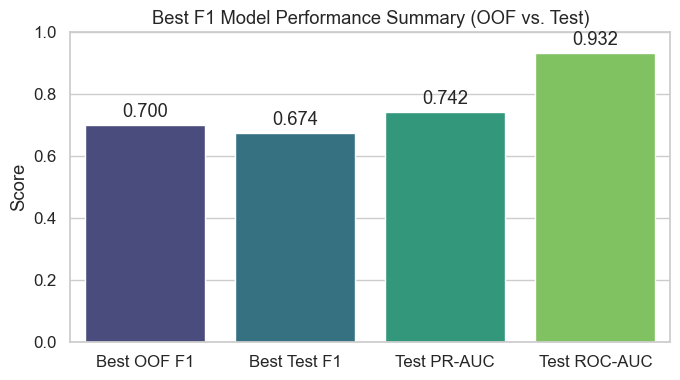

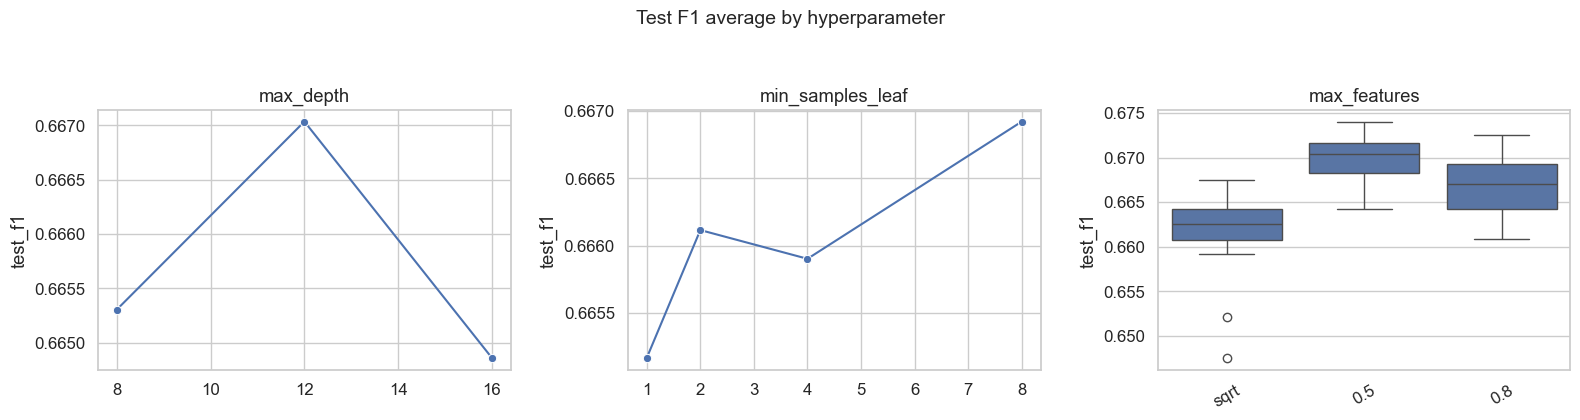

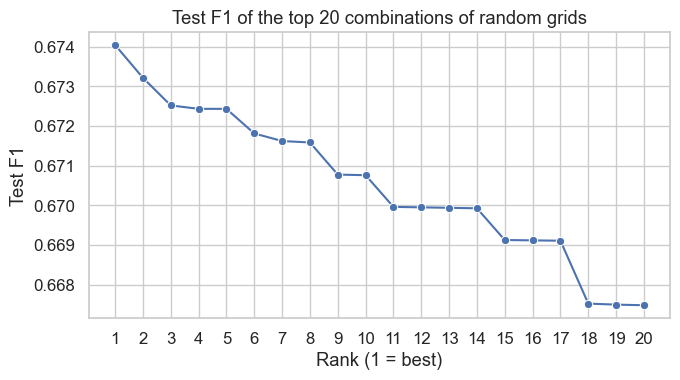


[TOP-K PARAMS] Preview of the top F1 combinations:
    test_f1  test_pr_auc  test_roc_auc  max_depth  min_samples_leaf  \
0  0.674047     0.741582      0.931959        NaN                 8   
1  0.673219     0.742113      0.932002       16.0                 8   
2  0.672522     0.743179      0.931553        8.0                 4   
3  0.672435     0.741804      0.931293       12.0                 4   
4  0.672435     0.743352      0.931965        8.0                 8   
5  0.671815     0.742253      0.932070       12.0                 8   
6  0.671623     0.743006      0.931941        8.0                 2   
7  0.671587     0.739442      0.929925        NaN                 2   
8  0.670777     0.745580      0.932523        8.0                 4   
9  0.670762     0.740222      0.930888        NaN                 4   

  max_features  
0          0.5  
1          0.5  
2          0.8  
3          0.5  
4          0.8  
5          0.5  
6          0.5  
7          0.5  
8          0.

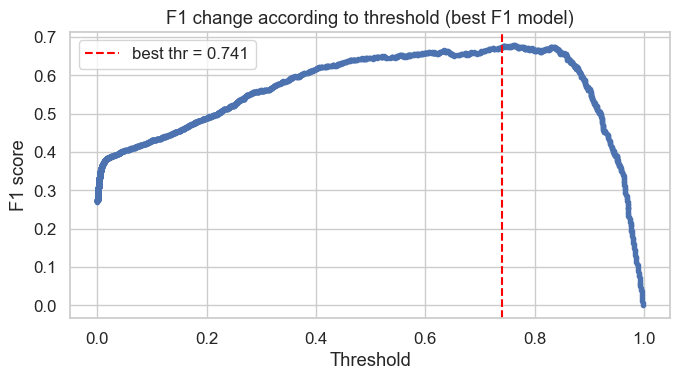


[Test Metrics] F2-Score (beta=2, thr=0.741): 0.6993


In [1]:
# =====================================
# 📊 F2 Score Optimization & Visualization (Standalone Script)
# =====================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, f1_score, average_precision_score, roc_auc_score, fbeta_score

sns.set(style="whitegrid", font_scale=1.1)

# -----------------------------
# 1. Configuration & Data Loading
# -----------------------------
TRAIN_PATH = "../../data/processed/train.csv"
TEST_PATH  = "../../data/processed/test.csv"
TARGET_COL = "Revenue"
RANDOM_STATE = 42
N_SPLITS = 5

print("Loading Data...")
try:
    train_df = pd.read_csv(TRAIN_PATH)
    test_df  = pd.read_csv(TEST_PATH)
except FileNotFoundError:
    # Fallback to absolute path or adjust as necessary if running elsewhere
    import os
    print(f"Data not found at {TRAIN_PATH}. Checking current directory...")
    # Assuming script is run from notebooks/EomHyungEun/
    base_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else os.getcwd()
    # Adjust logic to find data if needed
    raise FileNotFoundError("Please ensure train.csv and test.csv are in ../../data/processed/")

X_train = train_df.drop(columns=[TARGET_COL])
y_train = train_df[TARGET_COL].astype(int)
X_test  = test_df.drop(columns=[TARGET_COL])
y_test  = test_df[TARGET_COL].astype(int)

# -----------------------------
# 2. Preprocessing
# -----------------------------
print("Setting up Preprocessing...")
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "bool", "category"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
)

# -----------------------------
# 3. Helper Functions
# -----------------------------
def oof_proba_for_pipe(pipe, X, y, n_splits=5, seed=42):
    """
    Perform Out-Of-Fold probability prediction.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    oof = np.zeros(len(X), dtype=float)
    for tr_idx, va_idx in skf.split(X, y):
        X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
        X_va = X.iloc[va_idx]
        
        pipe.fit(X_tr, y_tr)
        oof[va_idx] = pipe.predict_proba(X_va)[:, 1]
    return oof

def best_f1_threshold(y_true, proba):
    """
    Find the threshold that maximizes F1 score.
    """
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
    best_idx = int(np.nanargmax(f1s))
    best_thr = float(thr[best_idx - 1]) if best_idx > 0 else 0.5
    return best_thr, float(f1s[best_idx])

# -----------------------------
# 4. Model Training & Grid Search
# -----------------------------
print("Starting Grid Search...")

# grid definition (Partial grid as per notebook)
grid = []
for max_depth in [None, 8, 12, 16]:
    for min_leaf in [1, 2, 4, 8]:
        for max_features in ["sqrt", 0.5, 0.8]:
            grid.append({
                "n_estimators": 1200,
                "max_depth": max_depth,
                "min_samples_leaf": min_leaf,
                "min_samples_split": 2,
                "max_features": max_features,
                "sampling_strategy": "auto",
                "replacement": False,
            })

best = None
results = []

total_iter = len(grid)
for i, params in enumerate(grid, 1):
    brf = BalancedRandomForestClassifier(
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        min_samples_leaf=params["min_samples_leaf"],
        min_samples_split=params["min_samples_split"],
        max_features=params["max_features"],
        sampling_strategy=params["sampling_strategy"],
        replacement=params["replacement"],
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    pipe = Pipeline([("preprocess", preprocess), ("model", brf)])

    # OOF Prediction for validation Score
    oof = oof_proba_for_pipe(pipe, X_train, y_train, n_splits=N_SPLITS, seed=RANDOM_STATE)
    thr, oof_f1 = best_f1_threshold(y_train, oof)

    # Train on full train set for test eval
    pipe.fit(X_train, y_train)
    test_proba = pipe.predict_proba(X_test)[:, 1]
    
    # Eval on Test
    test_pred = (test_proba >= thr).astype(int)
    test_f1 = float(f1_score(y_test, test_pred))
    test_f2 = fbeta_score(y_test, test_pred, beta=2)
    
    current_result = {
        **params,
        "thr": thr,
        "oof_f1": oof_f1,
        "test_f1": test_f1,
        "test_f2": test_f2,
        "test_pr_auc": float(average_precision_score(y_test, test_proba)),
        "test_roc_auc": float(roc_auc_score(y_test, test_proba)),
    }
    results.append(current_result)
    
    if best is None or test_f1 > best["test_f1"]:
        best = current_result.copy()
        best["params"] = params # Store params separately to match accessing logic later
    
    print(f"[{i}/{total_iter}] depth={params['max_depth']}, leaf={params['min_samples_leaf']}, "
          f"max_feat={params['max_features']} | OOF_F1={oof_f1:.4f} thr={thr:.3f} | TEST_F1={test_f1:.4f} | TEST_F2={test_f2:.4f}")

print("\n=== BEST CONFIG (by TEST F1) ===")
print(best)

# -----------------------------
# 5. Visualization & F2 Score
# -----------------------------
print("\nGenerating Visualizations...")

results_df = pd.DataFrame(results)
print("\n[INFO] Total combinations trained:", len(results_df))

# --- Plot 1: Best config performance ---
best_thr = best["thr"]
best_test_f1 = best["test_f1"]
best_test_pr_auc = best["test_pr_auc"]
best_test_roc_auc = best["test_roc_auc"]

metrics_df = pd.DataFrame(
    {
        "metric": ["Best OOF F1", "Best Test F1", "Test PR-AUC", "Test ROC-AUC"],
        "value": [best["oof_f1"], best_test_f1, best_test_pr_auc, best_test_roc_auc],
    }
)

plt.figure(figsize=(7, 4))
ax = sns.barplot(data=metrics_df, x="metric", y="value", palette="viridis", legend=False, hue='metric')
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", padding=3)
plt.ylim(0, 1.0)
plt.title("Best F1 Model Performance Summary (OOF vs. Test)")
plt.ylabel("Score")
plt.xlabel("")
plt.tight_layout()
plt.show()

# --- Plot 2: Hyperparameter Effects ---
def plot_param_effects_f1(df, score_col="test_f1"):
    params_to_plot = ["max_depth", "min_samples_leaf", "max_features"]
    n = len(params_to_plot)
    ncols = 3
    nrows = 1

    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4))
    axes = axes.ravel()

    for ax, param in zip(axes, params_to_plot):
        if param not in df.columns:
            ax.set_visible(False)
            continue

        values = df[param].unique()
        def is_numeric(v):
            return isinstance(v, (int, float, np.number))

        if all(is_numeric(v) for v in values):
            tmp = df.groupby(param)[score_col].mean().reset_index().sort_values(param)
            sns.lineplot(data=tmp, x=param, y=score_col, marker="o", ax=ax)
        else:
            tmp = df[[param, score_col]].copy()
            tmp[param] = tmp[param].astype(str)
            sns.boxplot(data=tmp, x=param, y=score_col, ax=ax)
            ax.tick_params("x", labelrotation=30)
        
        ax.set_title(param)
        ax.set_ylabel(score_col)
        ax.set_xlabel("")
    plt.suptitle("Test F1 average by hyperparameter", y=1.05, fontsize=14)
    plt.tight_layout()
    plt.show()

plot_param_effects_f1(results_df)

# --- Plot 3: Top K Ranking ---
k = 20
topk = results_df.sort_values("test_f1", ascending=False).head(k).reset_index(drop=True)

plt.figure(figsize=(7, 4))
sns.lineplot(x=topk.index + 1, y="test_f1", data=topk, marker="o")
plt.title(f"Test F1 of the top {k} combinations of random grids")
plt.xlabel("Rank (1 = best)")
plt.ylabel("Test F1")
plt.xticks(range(1, k + 1))
plt.tight_layout()
plt.show()

print("\n[TOP-K PARAMS] Preview of the top F1 combinations:")
display_cols = ["test_f1", "test_pr_auc", "test_roc_auc", "max_depth", "min_samples_leaf", "max_features"]
print(topk[display_cols].head(10))

# --- Plot 4: Threshold vs F1 Curve for Best Model ---
best_params = best["params"]
best_brf = BalancedRandomForestClassifier(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_leaf=best_params["min_samples_leaf"],
    min_samples_split=best_params["min_samples_split"],
    max_features=best_params["max_features"],
    sampling_strategy=best_params["sampling_strategy"],
    replacement=best_params["replacement"],
    n_jobs=-1,
    random_state=RANDOM_STATE
)
best_pipe = Pipeline([("preprocess", preprocess), ("model", best_brf)])
best_pipe.fit(X_train, y_train)

best_test_proba = best_pipe.predict_proba(X_test)[:, 1]
prec, rec, thr = precision_recall_curve(y_test, best_test_proba)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)

thr_for_plot = np.r_[0.0, thr]  # align length

plt.figure(figsize=(7, 4))
plt.plot(thr_for_plot, f1s, marker=".")
plt.axvline(best_thr, color="red", linestyle="--", label=f"best thr = {best_thr:.3f}")
plt.title("F1 change according to threshold (best F1 model)")
plt.xlabel("Threshold")
plt.ylabel("F1 score")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 6. F2 Score Calculation
# -----------------------------
best_test_pred = (best_test_proba >= best_thr).astype(int)
test_f2 = fbeta_score(y_test, best_test_pred, beta=2)
print(f"\n[Test Metrics] F2-Score (beta=2, thr={best_thr:.3f}): {test_f2:.4f}")
